In [1]:
#Ref1: https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/
#Ref2: https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/

from pickle import load

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import os
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import keras
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

from keras import backend as K
from keras import __version__
print('Using Keras version:', __version__, 'backend:', K.backend())

Using Keras version: 2.4.3 backend: tensorflow


In [2]:
def read_dataset(file_path):
    #Open from .txt files
    dataset = []
    with open(file_path, encoding='utf-8') as f:
        dataset = f.readlines()
        f.close()
    return dataset

def split_input_target(dataset):
    datasetLength = len(dataset)

    # Split into English Sentence and Portuguese Sentences
    eng_sen =  [] #English Sentence
    port_sen =  [] #Portuguese Sentence

    for line in dataset:
        splited = line.split('|')
        eng_sen.append(splited[0])
        port_sen.append(splited[1])

    return [eng_sen, port_sen]


In [3]:
def cleaning_punctuation_and_uppercase(sentence_list):
    sentence_list  = [((sen.strip()).translate(str.maketrans('', '', string.punctuation))).lower() for sen in sentence_list]
    return sentence_list

def visualize_length_of_sentences(title, senX, senY):
    senX = [len(sen.split()) for sen in senX]
    senY = [len(sen.split()) for sen in senY]
    length_df = pd.DataFrame({'English': senX, 'Portuguese': senY})
    length_df.hist(bins = 30)
    plt.xticks(range(0, 15, 1))
    plt.xlabel('#Word', fontsize=18)
    plt.ylabel('#Sentences', fontsize=16)
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    #fig.save(title+".jpg")
    plt.show()

In [4]:
def tokenizer(sentence_list):
    tok = tf.keras.preprocessing.text.Tokenizer()
    tok.fit_on_texts(sentence_list)
    return  tok #tok.sequences_to_matrix(tok.texts_to_sequences(sentence_list), mode='tfidf')

# Text Encoding into sequences and pad to make equal feature length to Train NN
def encode_text_to_sequences(tokenizer, max_sen_length, sentence_list):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(sentence_list)
    # pad sequences with 0 values
    seq = keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_sen_length, padding='post')
    return seq

def max_length(data):
    mx = 0
    for i in range(len(data)):
        mx = max(mx, len(data[i]))
    return mx

# Validation Data Process
validation_dataset = read_dataset("dev_best.txt")
val_eng_sen, val_port_sen = split_input_target(validation_dataset)

val_eng_sen = cleaning_punctuation_and_uppercase(val_eng_sen)
val_port_sen = cleaning_punctuation_and_uppercase(val_port_sen)

print('Validation English Datalen: '+str(len(val_eng_sen)))
print('Validation Portugu Datalen: '+str(len(val_port_sen)))

# Test Data Process
test_dataset = read_dataset("test.txt")
test_eng_sen, test_port_sen = split_input_target(test_dataset)

test_eng_sen = cleaning_punctuation_and_uppercase(test_eng_sen)
test_port_sen = cleaning_punctuation_and_uppercase(test_port_sen)

print('Test English Datalen: '+str(len(test_eng_sen)))
print('Test Portugu Datalen: '+str(len(test_port_sen)))
    

Validation English Datalen: 500
Validation Portugu Datalen: 500
Test English Datalen: 67865
Test Portugu Datalen: 67865


In [5]:
    dataset = read_dataset("dataset_1.txt")

    #dataset = read_dataset(root + 'datasets/modified_datasets/dataset_'+str(i)+'.txt')
    eng_sen, port_sen = split_input_target(dataset)

    #Cleaning
    eng_sen = cleaning_punctuation_and_uppercase(eng_sen)
    port_sen = cleaning_punctuation_and_uppercase(port_sen)

    #Plot Sentences
    #visualize_length_of_sentences("modified dataset "+str(i), eng_sen, port_sen)

    #tokenize
    eng_tok = tokenizer(eng_sen+val_eng_sen+test_eng_sen)
    port_tok = tokenizer(port_sen+val_port_sen+test_port_sen)

    #Max word length in Sentence
    max_eng_sen_word_length  = max_length(eng_sen+val_eng_sen+test_eng_sen)
    max_port_sen_word_length = max_length(port_sen+val_port_sen+test_port_sen)

    #Vocab Size
    eng_vocab_size = len(eng_tok.word_index)+1
    port_vocab_size = len(port_tok.word_index)+1
    print('English Vocab Size: ' + str(eng_vocab_size))
    print('Portugu Vocab Size: ' + str(port_vocab_size))

    #train encoding text to sequence
    train_eng_enc_seq = encode_text_to_sequences(eng_tok, max_eng_sen_word_length, eng_sen)
    train_port_enc_seq = encode_text_to_sequences(port_tok, max_port_sen_word_length, port_sen)

    #validation enc text to seq
    val_eng_enc_seq = encode_text_to_sequences(eng_tok, max_eng_sen_word_length, val_eng_sen)
    val_port_enc_seq = encode_text_to_sequences(port_tok, max_port_sen_word_length, val_port_sen)

    #test enc text to seq
    test_eng_enc_seq = encode_text_to_sequences(eng_tok, max_eng_sen_word_length, test_eng_sen)
    test_port_enc_seq = encode_text_to_sequences(port_tok, max_port_sen_word_length, test_port_sen)



English Vocab Size: 2584
Portugu Vocab Size: 5156


In [6]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, hidden_size):
  use_dropout = True
  model = Sequential()
  model.add(Embedding(src_vocab, hidden_size, input_length = src_timesteps, mask_zero=True))
  model.add(LSTM(hidden_size))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(hidden_size, return_sequences=True))
  if use_dropout:
    model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(tar_vocab, activation = 'softmax')))
  
  return model

# define model
model = define_model(eng_vocab_size, port_vocab_size, max_eng_sen_word_length, max_port_sen_word_length, 512)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# summarize defined model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 65, 512)           1323008   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 86, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 86, 512)           2099200   
_________________________________________________________________
dropout (Dropout)            (None, 86, 512)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 86, 5156)          2645028   
Total params: 8,166,436
Trainable params: 8,166,436
Non-trainable params: 0
______________________________________________

Mounted at /content/gdrive
Epoch 1/50
63/63 [==============================] - 43s 118ms/step - loss: 3.0230 - val_loss: 0.7417

Epoch 00001: val_loss improved from inf to 0.74168, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 2/50
63/63 [==============================] - 6s 92ms/step - loss: 0.7124 - val_loss: 0.6699

Epoch 00002: val_loss improved from 0.74168 to 0.66988, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 3/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6448 - val_loss: 0.5615

Epoch 00003: val_loss improved from 0.66988 to 0.56149, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 4/50
63/63 [==============================] - 6s 95ms/step - loss: 0.5503 - val_loss: 0.4799

Epoch 00004: val_loss improved from 0.56149 to 0.47989, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 5/50
63/63 [==============================] - 6s 95ms/step - loss: 0.4942 - val_loss: 0.4834

Epoch 00005: val_loss did not improve from 0.47989
Epoch 6/50
63/63 [==============================] - 6s 95ms/step - loss: 0.5017 - val_loss: 0.4680

Epoch 00006: val_loss improved from 0.47989 to 0.46804, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 7/50
63/63 [==============================] - 6s 97ms/step - loss: 0.4812 - val_loss: 0.4679

Epoch 00007: val_loss improved from 0.46804 to 0.46793, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 8/50
63/63 [==============================] - 6s 97ms/step - loss: 0.4659 - val_loss: 0.4587

Epoch 00008: val_loss improved from 0.46793 to 0.45870, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 9/50
63/63 [==============================] - 6s 96ms/step - loss: 0.4552 - val_loss: 0.4573

Epoch 00009: val_loss improved from 0.45870 to 0.45727, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 10/50
63/63 [==============================] - 6s 97ms/step - loss: 0.4476 - val_loss: 0.4543

Epoch 00010: val_loss improved from 0.45727 to 0.45429, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 11/50
63/63 [==============================] - 6s 96ms/step - loss: 0.4457 - val_loss: 0.4535

Epoch 00011: val_loss improved from 0.45429 to 0.45347, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 12/50
63/63 [==============================] - 6s 96ms/step - loss: 0.4349 - val_loss: 0.4502

Epoch 00012: val_loss improved from 0.45347 to 0.45021, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 13/50
63/63 [==============================] - 6s 96ms/step - loss: 0.4322 - val_loss: 0.4491

Epoch 00013: val_loss improved from 0.45021 to 0.44915, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 14/50
63/63 [==============================] - 6s 97ms/step - loss: 0.4292 - val_loss: 0.4510

Epoch 00014: val_loss did not improve from 0.44915
Epoch 15/50
63/63 [==============================] - 6s 95ms/step - loss: 0.4254 - val_loss: 0.4511

Epoch 00015: val_loss did not improve from 0.44915
Epoch 16/50
63/63 [==============================] - 6s 97ms/step - loss: 0.4209 - val_loss: 0.4495

Epoch 00016: val_loss did not improve from 0.44915
Epoch 17/50
63/63 [==============================] - 6s 97ms/step - loss: 0.4192 - val_loss: 0.4500

Epoch 00017: val_loss did not improve from 0.44915
Epoch 18/50
63/63 [==============================] - 6s 96ms/step - loss: 0.4212 - val_loss: 0.4510

Epoch 00018: val_loss did not improve from 0.44915
Epoch 19/50
63/63 [==============================] - 6s 95ms/step - loss: 0.4172 - val_loss: 0.4532

Epoch 00019: val_loss did not improve from 0.44915
Epoch 20/50
63/63 [==============================] - 6s 95ms/step - loss: 0.4140 - val_l

INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 47/50
63/63 [==============================] - 6s 94ms/step - loss: 0.3454 - val_loss: 0.4499

Epoch 00047: val_loss did not improve from 0.44852
Epoch 48/50
63/63 [==============================] - 6s 94ms/step - loss: 0.3351 - val_loss: 0.4492

Epoch 00048: val_loss did not improve from 0.44852
Epoch 49/50
63/63 [==============================] - 6s 94ms/step - loss: 0.3324 - val_loss: 0.4472

Epoch 00049: val_loss improved from 0.44852 to 0.44720, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


Epoch 50/50
63/63 [==============================] - 6s 95ms/step - loss: 0.3297 - val_loss: 0.4462

Epoch 00050: val_loss improved from 0.44720 to 0.44620, saving model to model.h1.d1_11_apr_21


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.d1_11_apr_21/assets


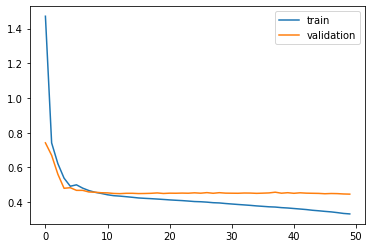

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
root = '/content/gdrive/MyDrive/Colab Notebooks/CMPUT566/'

filename = 'model.h1.d1_11_apr_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(train_eng_enc_seq, train_port_enc_seq, epochs=50, batch_size=64, validation_split=0, validation_data = (val_eng_enc_seq, val_port_enc_seq), callbacks = [checkpoint], verbose=1)

model.save('model.h1.d1_11_apr_21')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root = '/content/gdrive/MyDrive/Colab Notebooks/CMPUT566/'

import keras
from keras.models import load_model
import pickle
import pandas as pd


def load(model_name):
    return load_model(model_name)

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

def predicted_text(preds, out_tok):
    pred_text = []
    for i in preds:
        temp = []
        for j in range(len(i)):
            t = get_word(i[j], out_tok)
            if j > 0:
                if (t == get_word(i[j-1], out_tok) or t == None):
                    temp.append('')
                else:
                    temp.append(t)
            else:
                if t == None:
                    temp.append('')
                else:
                    temp.append(t)
        pred_text.append(' '.join(temp))
    return pred_text


model = load('model.h1.d1_11_apr_21')

preds = model.predict_classes(test_eng_enc_seq, batch_size = 2048)

pred_text = predicted_text(preds, port_tok)
actc_text = predicted_text(test_port_enc_seq, port_tok)

pred_df = pd.DataFrame({'actual' : actc_text, 'predicted' : pred_text})
pred_df.sample(15)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
